## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [89]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks`


In [90]:
Pkg.add(["Plots","Distributions","Random","Statistics","NonlinearSolve","ForwardDiff", "Optim"])

    Updating registry at `C:\Users\steal\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Project.toml`
⌃ [429524aa] + Optim v1.11.0
  No Changes to `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Manifest.toml`


In [1]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra

In [4]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [5]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [6]:
x = 0:0.1:10

0.0:0.1:10.0

In [7]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [8]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

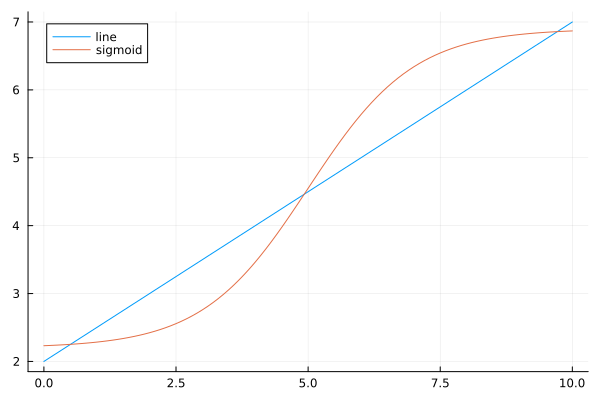

In [7]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [9]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  1.5870223261955014
  4.300403178073673
  4.385247924043718
  7.195317890483001
  2.09660202231382
  9.10125442813601
  4.465445258714272
 -2.6050563559583604
  4.27733253914601
  3.2681612158391884
  ⋮
  0.9320954183227252
  0.558266336814802
  2.7554898754224983
  7.255986640026659
  7.620055884804234
 13.560886698620303
  3.0200717185837194
  7.533323864815742
  6.190016116496347

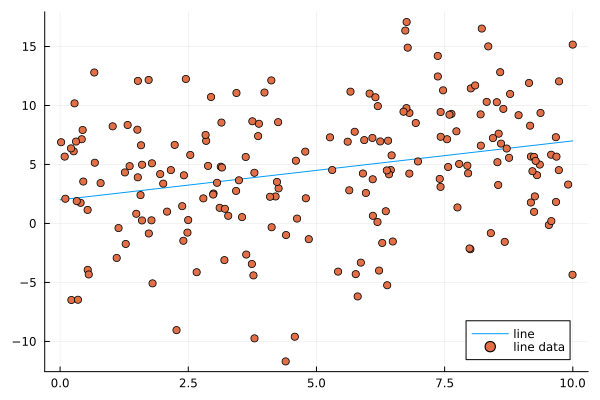

In [9]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

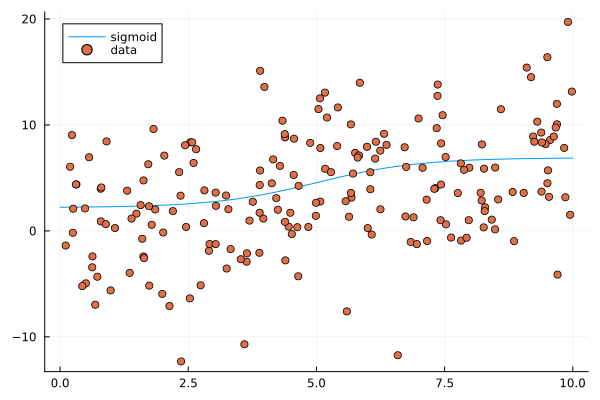

In [10]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

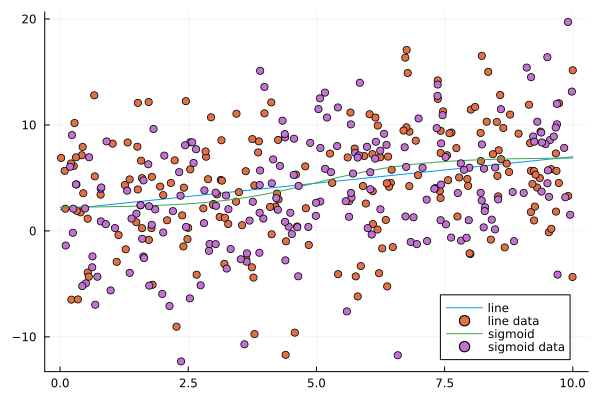

In [11]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [1]:
using LsqFit, Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra

function line_fitting(x, y; sigma=[])
    #Parameters initial guess
    p0 = [1.0, 2.0]

    #Fit the model to the data
    fit = curve_fit(line_fit, x, y, p0)
    #Best-fit parameters
    p_fit = fit.param 

    #Define the residuals function
    local_residuals(p) = y .- line_fit(x, p)

    #Estimation of sigma if it is not given
    if isempty(sigma)
        #Calculate residuals and use their standard deviation as the error estimate
        residuals = local_residuals(p_fit)
        
        #Estimate sigma as the std of residuals (least squares)
        sigma_value = std(residuals)
        sigma = sigma_value * ones(length(x))  # Assign sigma for each data point
        
        println("Estimated sigma: ", sigma[1])
    end
    
    #Calculate chi-squared
    chi2 = p -> sum((local_residuals(p) ./ sigma).^2)

    #Hessian matrix
    hess = ForwardDiff.hessian(chi2, p_fit)
    
    #Covariance matrix (inverse of the Hessian matrix)
    covariance_matrix = inv(2 * hess)
    
    #Errors (standard deviations of the parameters)
    errors = sqrt.(diag(covariance_matrix))
    
    #Final chi-squared value
    chi2_val = chi2(p_fit)

    return p_fit, covariance_matrix, chi2_val, errors
end


line_fitting (generic function with 1 method)

In [6]:
x = 10 .* rand(200)
p = [1.0, 2.0]
line_fit(x,p) = p[1] .+ p[2] .* x
y_exp = p[1] .* x .+ p[2] .+ 0.1 .* randn(length(x))

#Call the line_fitting function with the data (if sigma is not specified, the estimated sigma will be shown)
p_fit, covariance_matrix, chi2_val, errors = line_fitting(x, y_exp)

intercept = p_fit[2]
slope = p_fit[1]

println("Parameters: ", p_fit)
println("Covariance Matrix: ", covariance_matrix)
println("Chi2 value: ", chi2_val)
println("Errors: ", errors)
reduced_chi2 = chi2_val ./ (length(y_exp) .- length(p_fit))
println("Reduced chi-squared: ", reduced_chi2)


Estimated sigma: 0.09863544973109815
Parameters: [2.0012539500744717, 0.9995588154577588]
Covariance Matrix: [5.2152612417941254e-5 -7.752814330160435e-6; -7.752814330160435e-6 1.5029755457040487e-6]
Chi2 value: 199.00000000000003
Errors: [0.007221676565586502, 0.0012259590310055425]
Reduced chi-squared: 1.0050505050505052


# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [7]:
using LsqFit, Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra
sigmoid_fit(x, p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4])))

function sigmoid_fitting(x, y; sigma=[])
    # Initial guess for parameters [offset, scale, steepness, midpoint]
    p0 = [0.0, 1.0, 1.0, 5.0]  # Adjust initial guess as needed

    # Fit the model to the data
    fit = curve_fit(sigmoid_fit, x, y, p0)
    # Best-fit parameters
    p_fit = fit.param 

    # Define the residuals function
    local_residuals(p) = y .- sigmoid_fit(x, p)  # Use sigmoid_fit here

    # Estimation of sigma if it is not given
    if isempty(sigma)
        # Calculate residuals and use their standard deviation as the error estimate
        residuals = local_residuals(p_fit)
        
        # Estimate sigma as the std of residuals (least squares)
        sigma_value = std(residuals)
        sigma = sigma_value * ones(length(x))  # Assign sigma for each data point
        
        println("Estimated sigma: ", sigma[1])
    end
    
    # Calculate chi-squared
    chi2 = p -> sum((local_residuals(p) ./ sigma).^2)

    # Compute Hessian matrix using ForwardDiff
    hess = ForwardDiff.hessian(chi2, p_fit)
    
    # Covariance matrix (inverse of the Hessian matrix)
    covariance_matrix = inv(2 * hess)
    
    # Errors (standard deviations of the parameters)
    errors = sqrt.(diag(covariance_matrix))
    
    # Final chi-squared value
    chi2_val = chi2(p_fit)

    return p_fit, covariance_matrix, chi2_val, errors
end


sigmoid_fitting (generic function with 1 method)

In [11]:
x = 10 .* rand(200)
p = [2.0, 1.0, 3.0, 5.0]
y_exp = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4]))) .+ 0.1 .* randn(length(x))

# Call the sigmoid_fitting function with the data (if sigma is not specified, the estimated sigma will be shown)
p_fit, covariance_matrix, chi2_val, errors = sigmoid_fitting(x, y_exp)

println("Parameters: ", p_fit)
println("Covariance Matrix: ", covariance_matrix)
println("Chi2 value: ", chi2_val)
println("Errors: ", errors)
reduced_chi2 = chi2_val / (length(y_exp) - length(p_fit))
println("Reduced chi-squared: ", reduced_chi2)


Estimated sigma: 0.0990072507611144
Parameters: [2.0040127044932152, 1.0006306093292203, 3.0579930473516095, 4.98970992284057]
Covariance Matrix: [2.838631981867305e-5 -2.9831106288845434e-5 0.00022541299301029091 3.0845586841611974e-5; -2.9831106288845448e-5 6.551806142450028e-5 -0.0004580880722308629 -5.895303310194462e-7; 0.00022541299301029116 -0.00045808807223086283 0.021254435616797383 0.00045480571224029015; 3.084558684161196e-5 -5.895303310193361e-7 0.0004548057122402866 0.0003699878065605078]
Chi2 value: 199.00000000000003
Errors: [0.005327881363044137, 0.00809432278973975, 0.14578901061738975, 0.01923506710569287]
Reduced chi-squared: 1.0153061224489797


# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [62]:
using LsqFit, ForwardDiff, Statistics

# Define models
line_fit(x, p) = p[1] .* x .+ p[2]
sigmoid_fit(x, p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4])))

# Posterior ratio between sigmoid and line fit
function p_ratio_sig_line(x, y; sigma=[], prior_ratio=1.0, λmin=0.0, λmax=10.0, δλ=1.0)
    function fit_model(fit_func, p0)
        fit = curve_fit(fit_func, x, y, p0)
        p_fit = fit.param
        residuals = y .- fit_func(x, p_fit)
        if isempty(sigma)
            # If no sigma is provided, estimate σ using the standard deviation of the residuals
            σ = std(residuals) * ones(length(x))
        elseif length(sigma) == 1
            # If a single sigma value is provided, fill a vector with it
            σ = fill(sigma, length(x))
        else
            # If a full vector of sigma values is provided, use it as-is
            σ = sigma
        end
        chi2 = sum((residuals ./ σ).^2)
        logL = -0.5 * chi2
        bic = length(p_fit) * log(length(y)) - 2 * logL
        return logL
    end

    # Log likelihoods
    logL_line = fit_model(line_fit, [1.0, 1.0])
    logL_sigmoid = fit_model(sigmoid_fit, [1.0, 2.0, 1.0, 5.0])

    # Compute posterior odds as per given equation
    prior_term = prior_ratio  # P(H1)/P(H2), can be adjusted
    parameter_penalty = (λmax - λmin) / (δλ * sqrt(2π))
    likelihood_ratio = exp(logL_sigmoid - logL_line)

    post_odds = prior_term * likelihood_ratio * parameter_penalty
    return post_odds
end


p_ratio_sig_line (generic function with 1 method)

In [ ]:
x = 10 .* rand(200)
p_sig = [1.0, 2.0, 1.5, 5.0]
y = sigmoid_fit(x, p_sig) .+ 0.1 .* randn(length(x))

posterior_ratio = p_ratio_sig_line(x, y)
println("Posterior Ratio (Sigmoid vs Line): ", posterior_ratio)

Posterior Ratio (Sigmoid vs Line): 4.056679954578628


In [ ]:
using LsqFit, ForwardDiff, Statistics

# Define models
line_fit(x, p) = p[1] .* x .+ p[2]
sigmoid_fit(x, p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4])))

# Posterior ratio between sigmoid and line fit
function p_ratio_sig_line(x, y; sigma = [])
    prior_ratio = 1.0                    # P(H1)/P(H2)
    param_prior_ratio = 1.0            # Product of sigmoid priors / product of line priors
    p0_line = [1.0, 1.0]                # Starting guess for line
    p0_sigmoid = [1.0, 2.0, 1.0, 5.0]    # Starting guess for sigmoid

    function fit_model(fit_func, p0)
        fit = curve_fit(fit_func, x, y, p0)
        p_fit = fit.param
        residuals = y .- fit_func(x, p_fit)
        
        if isempty(sigma)
            σ = std(residuals) * ones(length(x))
        elseif length(sigma) == 1
            σ = fill(sigma, length(x))
        else
            σ = sigma
        end

        chi2 = sum((residuals ./ σ).^2)
        logL = -0.5 * chi2
        return logL
    end

    # Compute log-likelihoods
    logL_line = fit_model(line_fit, p0_line)
    logL_sigmoid = fit_model(sigmoid_fit, p0_sigmoid)

    # Final posterior odds
    likelihood_ratio = exp(logL_sigmoid - logL_line)
    post_odds = prior_ratio * likelihood_ratio * param_prior_ratio

    return post_odds
end


In [ ]:
# Generate synthetic data
x = range(0, stop=10, length=50)
true_params = [1.0, 2.0, 1.0, 5.0]
y = sigmoid_fit(x, true_params) .+ 0.1 .* randn(length(x))

# Assume equal model priors, but parameter priors favor line slightly
# E.g., param_prior_ratio = (0.1)^4 / (0.5)^2 = 0.0001 / 0.25 = 0.0004
posterior_odds = p_ratio_sig_line(x, y;sigma = 0.1)
    prior_ratio = 1.0
    param_prior_ratio = 0.0004
    p0_line = [0.5, 0.5]
    p0_sigmoid = [1.0, 2.0, 1.0, 5.0]

println("Posterior odds (sigmoid vs. line): ", posterior_odds)

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

In [74]:
using LsqFit, ForwardDiff, Statistics, Optim

function sig_p_ratio_is_one(x, y; sigma=[])
    # --- Define models
    line_fit(x, p) = p[1] .* x .+ p[2]
    sigmoid_fit(x, p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4])))

    # --- BIC calculation
    function compute_bic(fit_func, p0, x, y, sigma)
        fit = curve_fit(fit_func, x, y, p0)
        residuals = y .- fit_func(x, fit.param)
        chi2 = sum((residuals ./ sigma).^2)
        log_likelihood = -0.5 * chi2
        k = length(fit.param)
        bic = k * log(length(y)) - 2 * log_likelihood
        return bic
    end

    # --- Estimate sigma if not provided
    if isempty(sigma)
        p0_line = [1.0, 1.0]
        fit_line = curve_fit(line_fit, x, y, p0_line)
        residuals = y .- line_fit(x, fit_line.param)
        sigma = std(residuals)
    end

    # --- Function to find sigma that makes posterior ratio = 1
    function diff_in_bic(log_sigma)
        test_sigma = fill(exp(log_sigma), length(y))
        bic_line = compute_bic(line_fit, [1.0, 1.0], x, y, test_sigma)
        bic_sigmoid = compute_bic(sigmoid_fit, [1.0, 2.0, 1.0, 5.0], x, y, test_sigma)
        return (bic_line - bic_sigmoid) / 2  # log posterior ratio
    end

    # --- Optimize log(sigma) to find where posterior ratio = 1
    result = Optim.optimize(x -> abs(diff_in_bic(x)), log(1e-3), log(10.0))
    optimal_log_sigma = Optim.minimizer(result)
    optimal_sigma = exp(optimal_log_sigma)

    return fill(optimal_sigma, length(y))
end

sig_p_ratio_is_one (generic function with 1 method)

In [81]:
# Example usage:
x = 10 .* rand(200)
true_params = [1.0, 2.0, 1.5, 5.0]
sigmoid_fit(x, p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3] .* (x .- p[4])))
y = sigmoid_fit(x, true_params) .+ 0.1 .* randn(length(x))

sigma_balance = sig_p_ratio_is_one(x, y)
println("Estimated sigma where posterior ratio is 1: ", sigma_balance[1])


Estimated sigma where posterior ratio is 1: 1.1085418180218194


## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.